# intro

The purpose of this notebook create the J terms for a single map grid cell at the surface, show the residuals and look at the comparable contributions of different terms

# packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# read grid and files

In [2]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Salt'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'SEAICEheatConsFix': 0,
    'conserveTr': 0,
    'seaice_variable_salinity_flag': 0
}

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
#mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [10]:
# read one basin or whole ASTE
whole = False
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


## Get the timesteps

In [11]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2014"] = np.arange(3,5,1)
# times["2014"] = np.arange(9,11,1)
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

In [12]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [13]:
# ocean and ice
AB_gT=0
AB_gS=0

# create the salt budget
### salt tendency

In [14]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s

In [15]:
tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean

budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=0)

### salt h conv

In [16]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)

# reshape and get the faces
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))

In [17]:
# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

In [18]:
# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['salthconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['salthconv'] = (budgO['salthconv'] + budgI['salthconv'])

### salt v convergence

In [19]:
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)

In [20]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

In [21]:
if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux

In [22]:
nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + sptop[:-1,:,:]
trWtop[0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = RAC * budgO['saltzconv']   # g/s
budgI['saltzconv'] = RAC * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

(50, 1350, 270)


In [23]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a cell

In [24]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell

In [25]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

### show salt is budgeted

In [29]:
# pick one point from face 3 and one point from face 1
pt = np.array([[10,500,4],       # this is organized as x,y,z
               [220,445,10]])

pt = np.array([[10,500,4],       # this is organized as x,y,z
               [100,600,10]])

# 0 540 50
pt = np.array([[50,540,4],       # this is organized as x,y,z
               [100,600,10]])

y,x = 540,50

In [30]:
# Data variables (as given in your initial code)
a = budgO['saltfluxes']['tend']
b = budgO['saltfluxes']['ADV_Sconv']
c = budgO['saltfluxes']['DF_Sconv']
d = budgO['saltfluxes']['KPP_Sconv']
e = zconv_top_salt.reshape(1,ny,nx)                 # only at surface, is the surface forcing  ((SFLUX + oceSPflx) * RAC) in g/s
f = sptop                                            # oceSPtnd contribution from the ice

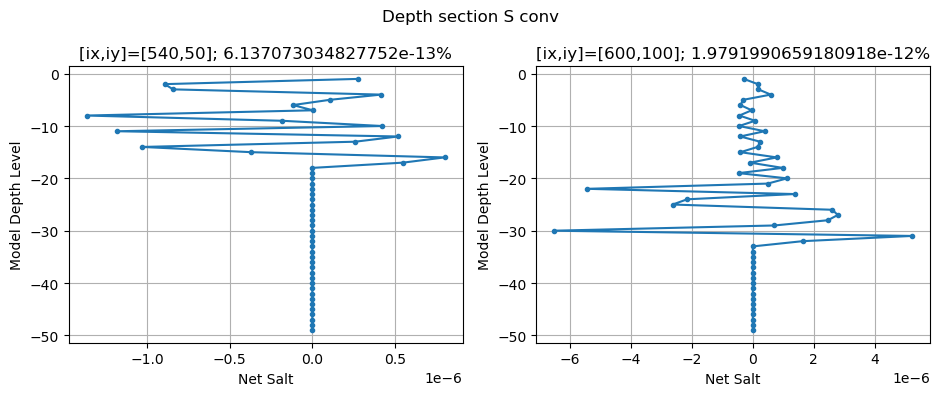

In [31]:
# also show the convergence at depth - I will make this a 1 by 2 plot so I can look at things easier

plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Depth section S conv")


n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:, n-1] += (f[1:,iy,ix] - f[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
aa[0, n-1] += f[0,iy,ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:, n-1] += (f[1:,iy,ix] - f[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
aa[0, n-1] += f[0,iy,ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]

plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()

# now do the heat budget
### start with the tendency

In [32]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/s

In [33]:
tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO['heatfluxes'] = {}
budgI['heatfluxes'] = {}

budgO['heatfluxes']['tend'] = tmptend     # J/s

budgO['heattend'] = np.nansum(tmptend,axis=0)

### do h convergence

In [34]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)

# get the faces so we can do convergence
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['heatfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['heathconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0),np.nansum(tmpVo,axis=0))

In [35]:
# add the budgeting for ADV and DF
tmpUo = get_aste_faces(ADVx_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

### do the vertical convergence

In [36]:
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))

In [37]:
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

In [38]:
geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))

In [39]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

In [40]:
budgO['heatzconv']=TFLUX+geothFlux+SPforcT1                           # W/m^2 = J/m^2/s
zconv_top_heat = TFLUX  * RAC     # W/m^2 * m^2 = J/s
budgI['heatzconv']=-(SItflux+TFLUX-TRELAX+SPforcT1)

if myparms['useNLFS']==0:
    print(1)
    budgO['heatzconv']=budgO['heatzconv']-myparms['rcp']*WTHMASS[:,:]     # degC.m/s * J/m^3degC = J/m^2.s

budgI['heatzconv']=budgI['heatzconv']-SIabflux+SIacflux+SIeprflx
if(myparms['SEAICEheatConsFix']==0):
    print(2)
    budgI['heatzconv']=budgI['heatzconv']+SIaaflux

2


In [41]:
nr = mygrid['RC'].shape[0]
trWtopADV = -(ADVr_TH) * myparms['rcp']         # J/s
trWtopDF = -(DFrE_TH+DFrI_TH) * myparms['rcp']  # J/s
trWtopKPP = -(KPPg_TH) * myparms['rcp']         # J/s
trWtop = trWtopADV + trWtopDF + trWtopKPP       # J/s
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)   # J/s
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323
    
trWtop[0,:,:]=budgO['heatzconv']*RAC
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

budgO["heatfluxes"]["trWtop"] = trWtop
budgO["heatfluxes"]["trWbot"] = trWbot

In [42]:
budgI["heatfluxes"]["trWtop"] = -RAC * (budgI["heatzconv"] + budgO["heatzconv"])
budgI["heatfluxes"]["trWbot"] = -RAC * budgO["heatzconv"]
budgO['heatfluxes']['zconv']=budgO['heatfluxes']['trWtop']-budgO['heatfluxes']['trWbot']

budgO['heatzconv'] = RAC*budgO['heatzconv']  # J/s
budgI['heatzconv']=RAC*budgI['heatzconv']    # J/s
budgOI['heatzconv']=budgO['heatzconv']+budgI['heatzconv']

In [43]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Tconv = budgO['heatfluxes']['ADV_hconv'] + tmpadv
budgO['heatfluxes']['ADV_Tconv'] = Tconv      # J/s, this is the advective arrow of T for a cell

In [44]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['heatfluxes']['DF_hconv'] + tmpdf
budgO['heatfluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

In [45]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['heatfluxes']['KPP_Tconv'] = tmpkpp        # no horizontal component for this

### Show that this is budgeted

In [46]:
# now we can plot these the same way as we did for salt
# Data variables (as given in your initial code)
a = budgO['heatfluxes']['tend']
b = budgO['heatfluxes']['ADV_Tconv']
c = budgO['heatfluxes']['DF_Tconv']
d = budgO['heatfluxes']['KPP_Tconv']
e = zconv_top_heat.reshape(1,ny,nx)                 # NOTE - this is only at the surface
f = swtop

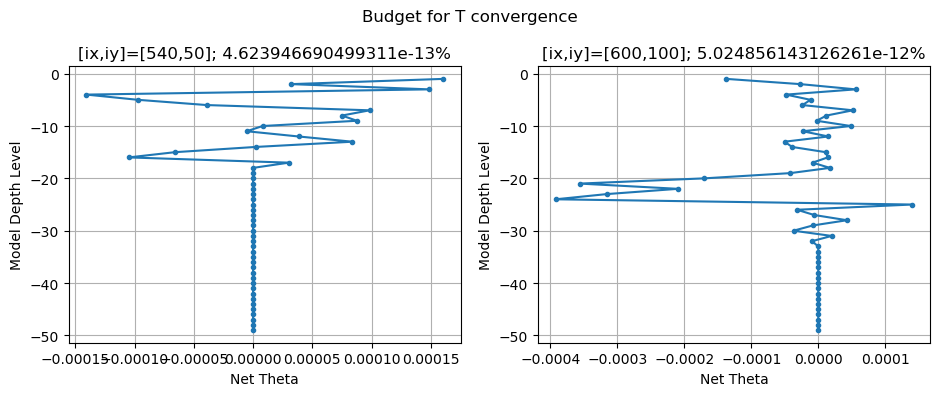

In [47]:
# show the convergence of heat at depth - I will make this a 1 by 2 plot so I can look at things easier
plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Budget for T convergence")

n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = (a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix])
aa[1:-1, n-1] += (f[2:,iy,ix] - f[1:-1,iy,ix])    # for swtop we want the difference between the top and bottom
aa[0, n-1] += f[1,iy,ix]
aa[0, n-1] -= zconv_top_heat[iy, ix]      # subtract the TFLUX at the surface only
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Theta")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['heatfluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:-1, n-1] += (f[2:,iy,ix] - f[1:-1,iy,ix])
aa[0, n-1] += f[1,iy,ix]
aa[0, n-1] -= zconv_top_heat[iy, ix]                   # this is because we already included the TFLUX
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Theta")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['heatfluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()

# get volume and TS values from bins

In [48]:
ffac = 1e-6

In [49]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [50]:
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

theta = THETA.reshape(nz,ny,nx)
salt = SALT.reshape(nz,ny,nx)

In [51]:
# create the bins of TS data
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)


# create the binned values for theta and salt
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [52]:
maskArc = mskBasin * mymsk

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])
# doing some reshaping here so that we can plot more easily
# mesh = create_TS_mesh(tsstr[:-1],nS,nT,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),vol,idxs,dT,dS)
# print(mesh.shape)

# if we want to do just the surface of the basin:
surf_vol = vol.copy()
surf_vol[:,1:,:,:] = np.nan
mesh = create_TS_mesh(tsstr[:-1],nS,nT,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),surf_vol,idxs,dT,dS)

In [53]:
# sum the volume from the points in dimension 2
vol_mesh = np.nansum(mesh[0],axis=2)

In [54]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

/tmp/ipykernel_871225/3690733599.py:12: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)


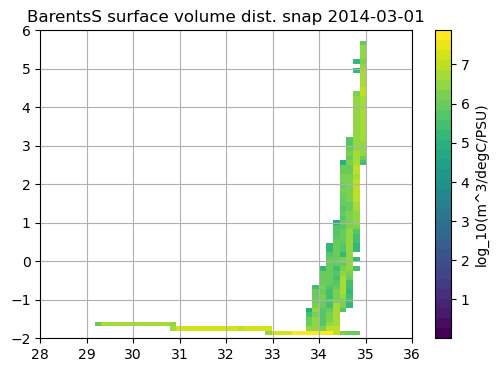

In [55]:
# just plot volume to start ( I am scared I messed something up )
# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(6,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = .25

ax1 = plt.subplot(111)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
# U1, V1 = -G_S_vec_m1,G_T_vec_m1/16
# q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=2e0)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title(strb[iB] + " surface volume dist. snap " + datetimes[0].strftime("%Y-%m-%d"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,6)
ax1.grid()
# ax1.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv")

# plt.savefig(path + "BarentsS_volume_March2014.png",dpi=300)

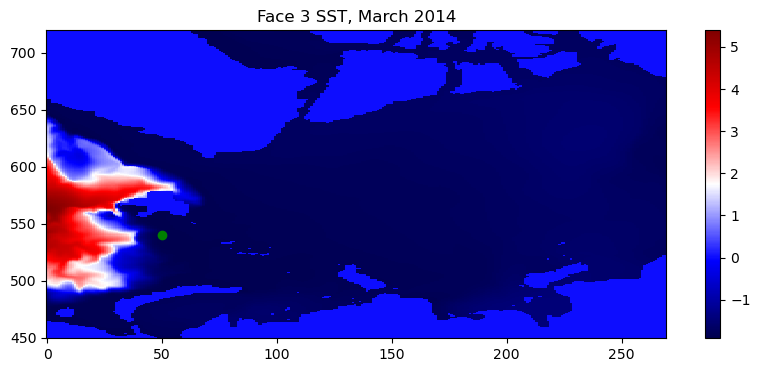

In [56]:
# pick a specific point
# plot for face 3
XV,YV = np.meshgrid(np.arange(0,270,1),np.arange(450,720,1))
plt.pcolormesh(XV,YV,theta[0][450:720,:270],cmap='seismic')
plt.colorbar()
# more extreme point at T_f
x = 50
y = 540
z = 0

# basic point in the middle range of TS
# x = 25
# y = 500
# z = 0

plt.plot(x,y,'o',color="green")
plt.title("Face 3 SST, March 2014")
plt.savefig(path + "BarentsS_pointatTf_March2014.png",dpi=300)

In [58]:
print("theta: ",theta[z,y,x])
print("salt: ",salt[z,y,x])

theta:  -1.8741419315338135
salt:  34.20693588256836


In [59]:
# get the indices for a sample TS bin
iTpt = int(binned_theta[z,y,x])
print("theta range: ",binsTH_edges[iTpt],"--",binsTH_edges[iTpt+1])
iSpt = int(binned_salinity[z,y,x])
print("salt range: ",binsSLT_edges[iSpt],"--",binsSLT_edges[iSpt+1])

# get the binwidth for that TS bin

theta range:  -1.9239130434782608 -- -1.8043478260869565
salt range:  34.146341463414636 -- 34.292682926829265


In [60]:
# pick this bin in the volume, mask it and plot
mesh_pt = np.zeros((nS, nT))
mesh_pt[iSpt,iTpt] += vol[0,z,y,x]

/tmp/ipykernel_871225/967850930.py:12: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)


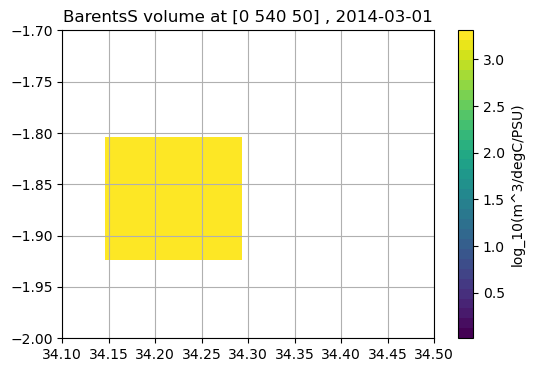

In [61]:
# just plot volume to start ( I am scared I messed something up )
# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(6,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = .25

ax1 = plt.subplot(111)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
# U1, V1 = -G_S_vec_m1,G_T_vec_m1/16
# q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=2e0)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title(strb[iB] + " volume at [" + str(z) + " " + str(y) + " " + str(x) + "] , " + datetimes[0].strftime("%Y-%m-%d"))
ax1.set_xlim(34.1,34.5)
ax1.set_ylim(-2,-1.7)
ax1.grid()
# ax1.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv")

plt.savefig(path + "BarentsS_volume_March2014_pt_tf.png",dpi=300)

In [66]:
# show the vectors for each
aT = budgO['heatfluxes']['tend']
bT = budgO['heatfluxes']['ADV_Tconv']
cT = budgO['heatfluxes']['DF_Tconv']
dT = budgO['heatfluxes']['KPP_Tconv']
eT = zconv_top_heat.reshape(1,ny,nx)
fT = swtop

aa = np.zeros((nz, 1))
n = 0
aa[:, n] = (aT[:, y, x] - bT[:, y, x] - cT[:, y, x] - dT[:, y, x])
aa[1:-1, n] += (fT[2:,y,x] - fT[1:-1,y,x])    # for swtop we want the difference between the top and bottom
aa[0, n] += fT[1,y,x]
aa[0, n] -= zconv_top_heat[y, x]      # subtract the TFLUX at the surface only

# save the J terms for here for the single point   
JtendT = (aT[0,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6             # m^3/s/PSU
JADVT = (bT[0,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6              # m^3/s/PSU
JDFT = (cT[0,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6               # m^3/s/PSU
JKPPT = (dT[0,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6              # m^3/s/PSU
JsurfT = (eT[0,y,x] - fT[1,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6 # m^3/s/PSU

# set these in meshes so we can plot
JtermsT = np.zeros((5,nS,nT))
c = 0
for valT in (np.array([JtendT,JADVT,JDFT,JKPPT,JsurfT])):
    #print(valT)
    JtermsT[c,iSpt,iTpt] = valT
    c += 1
print()
# JtermsT[JtermsT == 0] = np.nan

# print the terms one by one
print("heat tendency: " ,aT[0,y,x])
print()
print("ADV heat conv: " ,bT[0,y,x])
print("DF heat conv: " , cT[0,y,x])
print("KPP heat conv: " ,dT[0,y,x])
print("TFLUX * RAC (top): "  , eT[0,y,x])
print("shortwave fraction (top): " ,fT[1,y,x])
print()
# print("residual: ",aa[0])
print("residual: ",aT[0,y,x]- bT[0,y,x] - cT[0,y,x] - dT[0,y,x] - eT[0,y,x] + fT[1,y,x], " J/s")
# print(100 * np.nanmax(np.abs(aa[:, n]))/np.nanmax(np.abs(budgO['heatfluxes']['zconv'][:,y, x])))


heat tendency:  -47349467.66030702

ADV heat conv:  -94093087.89439917
DF heat conv:  7528822668.977098
KPP heat conv:  11029513018.037693
TFLUX * RAC (top):  -17882999975.805607
shortwave fraction (top):  628592090.9752531

residual:  0.00015926361083984375  J/s


In [67]:
# show the vectors for each
aS = budgO['saltfluxes']['tend']
bS = budgO['saltfluxes']['ADV_Sconv']
cS = budgO['saltfluxes']['DF_Sconv']
dS = budgO['saltfluxes']['KPP_Sconv']
eS = zconv_top_salt.reshape(1,ny,nx)
fS = sptop

aa = np.zeros((nz, 1))
n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = aS[:, iy, ix] - bS[:, iy, ix] - cS[:, iy, ix] - dS[:, iy, ix]
aa[1:, n-1] += (fS[1:,iy,ix] - fS[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
aa[0, n-1] += fS[0,iy,ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]

# save the J terms for here for the single point   
JtendS = (aS[0,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6             # m^3/s/degC
JADVS = (bS[0,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6              # m^3/s/degC
JDFS = (cS[0,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6               # m^3/s/degC
JKPPS = (dS[0,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6              # m^3/s/degC
JsurfS= (eS[0,y,x] - fS[1,y,x]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] #* 1e-6 # m^3/s/degC

# set these in meshes so we can plot
JtermsS = np.zeros((5,nS,nT))
c = 0
for valT in (np.array([JtendT,JADVT,JDFT,JKPPT,JsurfT])):
    #print(valT)
    JtermsS[c,iSpt,iTpt] = valT
    c += 1
print()
# JtermsT[JtermsT == 0] = np.nan

# print the terms one by one
print("heat tendency: " ,aS[0,y,x])
print()
print("ADV heat conv: " ,bS[0,y,x])
print("DF heat conv: " , cS[0,y,x])
print("KPP heat conv: " ,dS[0,y,x])
print("TFLUX * RAC (top): "  , eS[0,y,x])
print("shortwave fraction (top): " ,fS[1,y,x])
print()
# print("residual: ",aa[0])
print("residual: ",aS[0,y,x]- bS[0,y,x] - cS[0,y,x] - dS[0,y,x] - eS[0,y,x] + fS[0,y,x], " J/s")
# print(100 * np.nanmax(np.abs(aa[:, n]))/np.nanmax(np.abs(budgO['heatfluxes']['zconv'][:,y, x])))


heat tendency:  51285.99253899379

ADV heat conv:  424031.6952833794
DF heat conv:  147030.25095036626
KPP heat conv:  -425225.1531757523
TFLUX * RAC (top):  -62681.58772408934
shortwave fraction (top):  31868.784317317324

residual:  2.7956775738857687e-07  J/s


/tmp/ipykernel_871225/1244372126.py:18: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_871225/1244372126.py:30: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_871225/1244372126.py:42: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_871225/1244372126.py:54: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_871225/1244372126.py:66: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_871225/1244372126.py:78: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmi

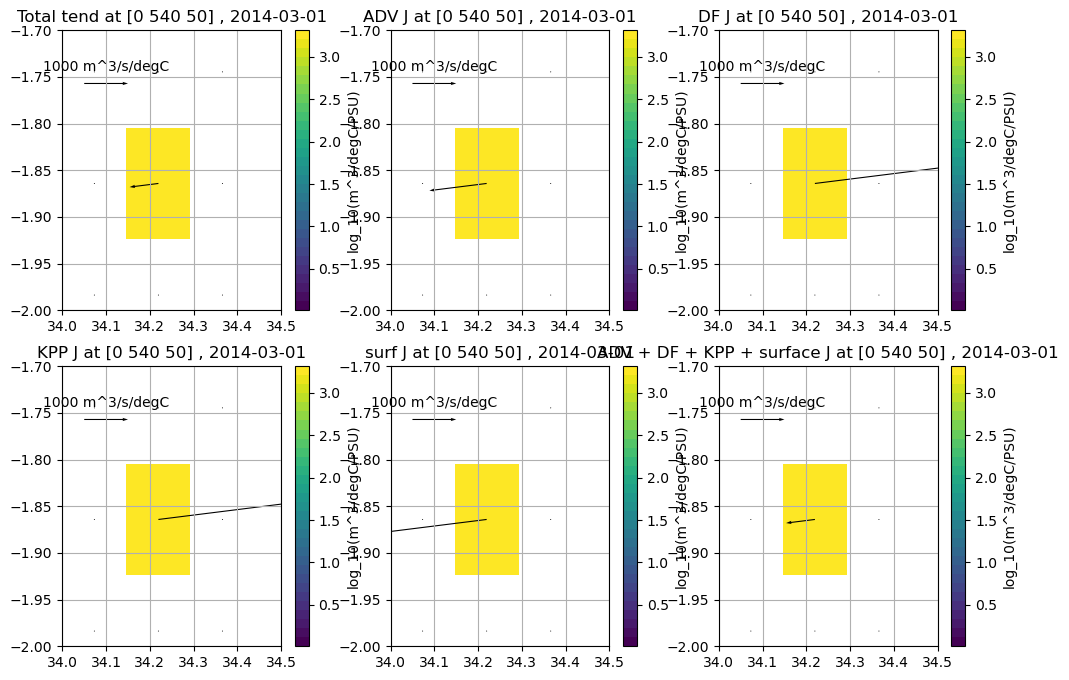

In [71]:
# plot these on a figure to show the budgeted terms
sfact = 8   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = 1000
scale = 5e3

xlims = np.array([34,34.5])
ylims = np.array([-2,-1.7])

# first get the values and do conversions to Sv/degC or Sv/PSU

fig = plt.figure(figsize = (12,8))

# add plot for total tendency for this square
ax = plt.subplot(231)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[0],JtermsT[0]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("Total tend at [" + str(z) + " " + str(y) + " " + str(x) + "] , " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " m^3/s/degC")

# for ADV tendency for this square
ax = plt.subplot(232)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[1],JtermsT[1]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("ADV J at [" + str(z) + " " + str(y) + " " + str(x) + "] , " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " m^3/s/degC")

# for DF tendency for this square
ax = plt.subplot(233)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[2],JtermsT[2]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("DF J at [" + str(z) + " " + str(y) + " " + str(x) + "] , " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " m^3/s/degC")

# for KPP tendency for this square
ax = plt.subplot(234)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[3],JtermsT[3]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("KPP J at [" + str(z) + " " + str(y) + " " + str(x) + "] , " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " m^3/s/degC")

# for surface tendency for this square
ax = plt.subplot(235)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[4],JtermsT[4]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("surf J at [" + str(z) + " " + str(y) + " " + str(x) + "] , " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " m^3/s/degC")

# for total tendency for this square from terms
ax = plt.subplot(236)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = (JtermsS[1] + JtermsS[2] + JtermsS[3] + JtermsS[4]),(JtermsT[1] + JtermsT[2] + JtermsT[3] + JtermsT[4])/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("ADV + DF + KPP + surface J at [" + str(z) + " " + str(y) + " " + str(x) + "] , " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " m^3/s/degC")

# save the figure for this point
plt.savefig(path + "singlept_allJterms_Tfpt.png",dpi=300)

In [ ]:
# maybe also plot the column